In [1]:
import os
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import matplotlib.patches as patches
import matplotlib.patches as patches
from skimage.transform import resize
from tqdm import tqdm
import glob

In [2]:
# video config
WIDTH = 100
HEIGHT = 100
DIM = 3
X_DIM = 3

WIDTH_FACTOR = 800 // WIDTH
HEIGHT_FACTOR = 600 // HEIGHT

In [3]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9, alpha=0.99):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius
        self.alpha = alpha

        self.W_in = np.random.rand(reservoir_size, input_size + 1) - 0.5  # bias term
        self.W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5 # bias term
        self.W_out = np.random.rand(output_size, reservoir_size) - 0.5    # bias term
        #self.x0 = np.random.rand(reservoir_size)

        self.W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_res)))

    def train(self, X_train, y_train, transient=100):
        X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_train), self.reservoir_size))
        x = np.zeros(self.reservoir_size)
        #x0 = np.random.rand(self.reservoir_size)

        for t in range(len(X_train)):
            u = X_train[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            #x = self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, self.x0))
            if t > transient:
                X_res[t] = x

        self.W_out = np.dot(np.linalg.pinv(X_res[transient:]), y_train[transient:])

    def predict(self, X_test):
        X_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_test), self.reservoir_size))
        x = np.zeros(self.reservoir_size)
        #x0 = np.random.rand(self.reservoir_size)

        for t in range(len(X_test)):
            u = X_test[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            #x = self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, self.x0))
            X_res[t] = x

        return np.dot(X_res, self.W_out)
    
    def identity(self, x):
        return softmax(x)

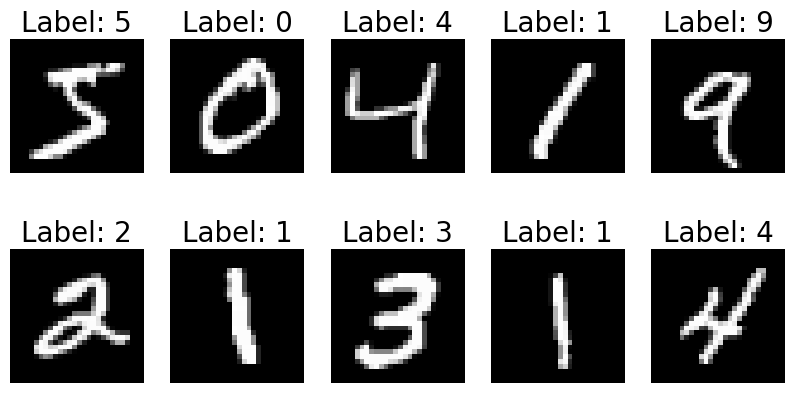

In [2]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def plot_mnist_images(images, labels, num_images=10, font_size=30):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}', fontsize=font_size)
        plt.axis('off')
    plt.show()

sample_images = train_images[:10]
sample_labels = train_labels[:10]

plot_mnist_images(sample_images, sample_labels, font_size=20)


In [4]:
def draw_bounding_boxes_from_array(video_path, bounding_boxes, output_video_path):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create a VideoWriter object for AVI format
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Read each frame, draw bounding boxes, and write to output video
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count < len(bounding_boxes):
            x, y = bounding_boxes[frame_count]
            x, y = int(x), int(y)
            width, height = 30, 30

            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

        out.write(frame)

        frame_count += 1

    cap.release()
    out.release()

    print(f"Bounding boxes added and new video saved to: {output_video_path}")

def read_png_image(file_path, name, i):

    file_name = os.path.basename(file_path)
    image_array = random_augment(file_path)
    #image_array = resize(image_array, (HEIGHT , WIDTH), anti_aliasing=True)

    number = int(file_name.split("_")[1].split(".")[0])
    df = pd.read_csv(f'assets/preprocessed_bb_coordinates/moving_{name}_{i}.csv')
    x = df['X-coordinate']
    y = df['Y-coordinate']

    x_coord = int(x[number] // WIDTH_FACTOR)
    y_coord = int(y[number] // HEIGHT_FACTOR)

    image_array = crop_image(image_array, x_coord, y_coord)

    return image_array, x_coord, y_coord

def plot_image(img, bb, save_path):

    fig, ax = plt.subplots()

    plt.imshow(img)
    x, y = (bb[0]-30)//WIDTH_FACTOR, (bb[1]-30)//HEIGHT_FACTOR
    rect = patches.Rectangle((x, y), 10, 10, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.savefig(save_path)
    plt.close() 

def zoom(image, scale=(1, 1.3)):
  zoom = iaa.Affine(scale=scale)
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.08, 0.08), "y":(-0.08, 0.08)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  # As of experience models recats better to darker immages
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

def random_augment(image):
  
  image = mpimg.imread(image)
  #if np.random.rand() < 0.5:
  #  image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  
  return image

def crop_image(image_array, x, y, output_size=(201, 201)):
    
    # Define the cropping box based on the object's location and the offset
    left = max(0, x - 100)
    upper = max(0, y - 100)
    right = min(WIDTH, x + 100)
    lower = min(HEIGHT, y + 100)
    
    # Crop the image array
    cropped_image_array = image_array[upper:lower, left:right]
    
    # Pad the cropped image to ensure consistent size
    pad_height = max(0, output_size[0] - cropped_image_array.shape[0])
    pad_width = max(0, output_size[1] - cropped_image_array.shape[1])
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    cropped_image_array = np.pad(cropped_image_array, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')
    
    return cropped_image_array

# MNIST

### Training

In [6]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Normalize pixel values to range [0, 1]
X = np.array(X)
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()

print(X.shape, y.shape)

c:\Users\ghorb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784) (70000, 10)


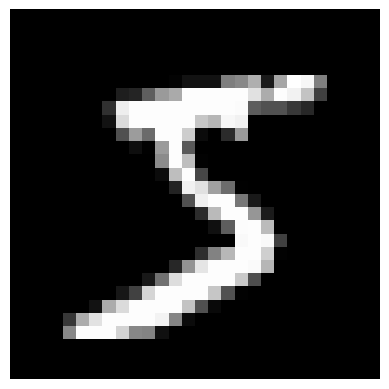

In [7]:
import matplotlib.pyplot as plt

def plot_image(image_array):
    """
    Plot an image from a NumPy array.
    
    Parameters:
        image_array (numpy.ndarray): The image array to be plotted.
    """
    plt.imshow(image_array.reshape(28, 28), cmap='gray') 
    plt.axis('off')  
    plt.show()

plot_image(X[0])

In [8]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000, 10)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Initialize and train ESN
input_size = X_train.shape[1]
reservoir_size = 4000
output_size = 10
esn = ESN(input_size, reservoir_size, output_size, alpha=0.99)
esn.train(X_train, y_train)

### Prediction

In [11]:
# Predict and evaluate
predictions = []
for i in X_test:
    predictions.append(esn.predict(i.reshape(1, -1)))
    #print(np.argmax(predictions))
predictions = np.array(predictions).reshape(-1, 10)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)

Accuracy: 0.9500714285714286


### Prediction on 1 image

In [ ]:
print("Ground truth label:", y_test[90])
print("Predicted label:", predictions[45])

In [ ]:
prediction_softmax = softmax(predictions[90])
print("Predicted probabilities:  ", np.argmax(prediction_softmax))
print("ground truth label:       ", np.argmax(y_test[90]))

# Shapes (External data)

In [17]:
import os
import random
from PIL import Image, ImageDraw

def generate_image_with_shape(shape_type, save_dir, index):
    width, height = 100, 100

    img = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(img)

    x = random.randint(10, width - 40)
    y = random.randint(10, height - 40)
    size = random.randint(20, 40)

    thickness = 3

    if shape_type == 'circle':
        draw.ellipse([(x, y), (x + size, y + size)], outline='black', width=thickness)
    elif shape_type == 'triangle':
        draw.polygon([(x, y), (x + size, y), (x + size // 2, y - size)], outline='black', width=thickness)
    elif shape_type == 'rectangle':
        draw.rectangle([(x, y), (x + size, y + size)], outline='black', width=thickness)

    img.save(os.path.join(save_dir, f'{shape_type}_{index}.png'))

def main():
    main_dir = 'assets/new_images_shape'
    os.makedirs(main_dir, exist_ok=True)
    shapes = ['circle', 'triangle', 'rectangle']

    num_images_per_shape = 700

    for shape in shapes:
        shape_dir = os.path.join(main_dir, shape)
        os.makedirs(shape_dir, exist_ok=True)

        n = 0
        for i in range(num_images_per_shape):
            generate_image_with_shape(shape, shape_dir, n)
            n += 1

if __name__ == "__main__":
    main()


In [4]:
main_folder = 'assets/new_images_shape'
Circle = os.path.join(main_folder, 'circle')
Square = os.path.join(main_folder, 'rectangle')
Triangle = os.path.join(main_folder, 'triangle')
folders = [Circle, Square, Triangle]

def load_images(folder, label):
    images = []
    labels = []
    f = 0
    for filename in tqdm(os.listdir(folder), desc=f"Loading images from {folder}"):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = Image.open(os.path.join(folder, filename))
            #img = img.resize((100, 100))
            img = np.array(img)
            images.append(img)
            labels.append(label)

        f += 1
        if f == 2000:
            break
    return images, labels

X = []
y = []
n = 0
for folder in folders:
    images, labels = load_images(folder, n)
    X.extend(images)
    y.extend(labels)
    n += 1

unique_labels = np.unique(y)
print("Unique labels:", unique_labels)

X = np.array(X)
X = np.reshape(X, (len(X), (100*100), DIM))
X_gray = np.dot(X[...,:DIM], np.array([0.2989, 0.5870, 0.1140]))
X = np.expand_dims(X_gray, axis=-1)
X = X[:, :, 0]
X = X / 255.0
X = np.array(X)

y = np.array(y)
y_encoded = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

print(X.shape)
print(y_encoded.shape)

Loading images from assets/new_images_shape\circle:  29%|██▊       | 1999/7000 [00:01<00:03, 1438.99it/s]
Loading images from assets/new_images_shape\rectangle:  29%|██▊       | 1999/7000 [00:01<00:03, 1555.83it/s]
Loading images from assets/new_images_shape\triangle:  29%|██▊       | 1999/7000 [00:01<00:03, 1547.28it/s]


Unique labels: [0 1 2]
(6000, 10000)
(6000, 3)


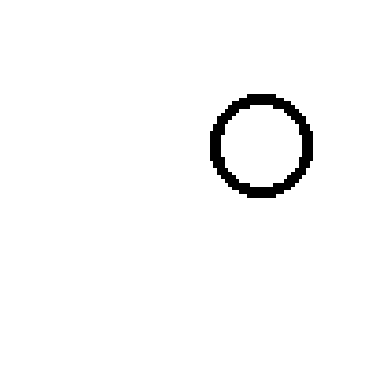

In [6]:
import matplotlib.pyplot as plt

def plot_image(image_array):
    plt.imshow(image_array.reshape(100, 100), cmap='gray') 
    plt.axis('off')
    plt.show()

plot_image(X[1000])


In [7]:
X.shape, y_encoded.shape
# write the name on the frame

((6000, 10000), (6000, 3))

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

In [9]:
# Initialize and train ESN
input_size = X_train.shape[1]
reservoir_size = 1000
output_size = y_train.shape[1]
esn = ESN(input_size, reservoir_size, output_size, alpha=0.85)
esn.train(X_train, y_train)

In [10]:
# Predict and evaluate
predictions = esn.predict(X_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)

Accuracy: 0.605


Alpha Progress: 100%|██████████| 100/100 [24:41<00:00, 14.82s/it]


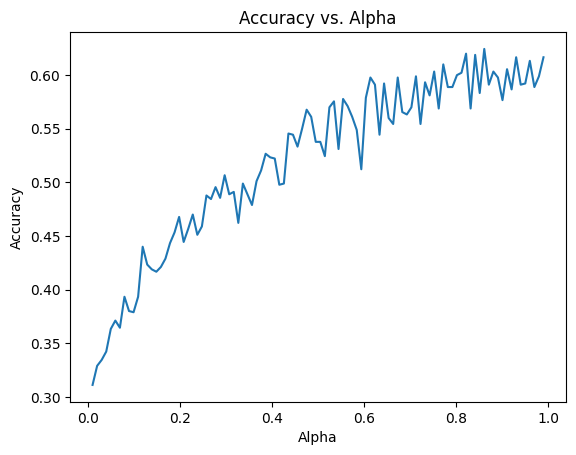

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

alpha_values = np.linspace(0.01, 0.99, 100)
accuracies = []

for alpha in tqdm(alpha_values, desc='Alpha Progress'):
    input_size = X_train.shape[1]
    reservoir_size = 500
    output_size = y_train.shape[1]
    esn = ESN(input_size, reservoir_size, output_size, alpha=alpha)
    esn.train(X_train, y_train)

    predictions = esn.predict(X_test)
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
    accuracies.append(accuracy)

plt.plot(alpha_values, accuracies)
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha')
plt.show()


In [37]:
with open("assets/accuracies_shape/accuracies_500.txt", "w") as file:
    # Iterate over the numbers and write each number to the file
    for number in accuracies:
        file.write(str(number) + "\n")

In [13]:
TEST = 470
print("Ground truth label:", y_test[TEST])
print("Predicted label:   ", predictions[TEST])

Ground truth label: [0. 0. 1.]
Predicted label:    [0.17329979 0.0671196  0.75990295]


In [14]:
prediction_softmax = softmax(predictions[TEST])
print("Predicted probabilities:  ", np.argmax(prediction_softmax))
print("ground truth label:       ", np.argmax(y_test[TEST]))

Predicted probabilities:   2
ground truth label:        2


# Pedestrian Detection

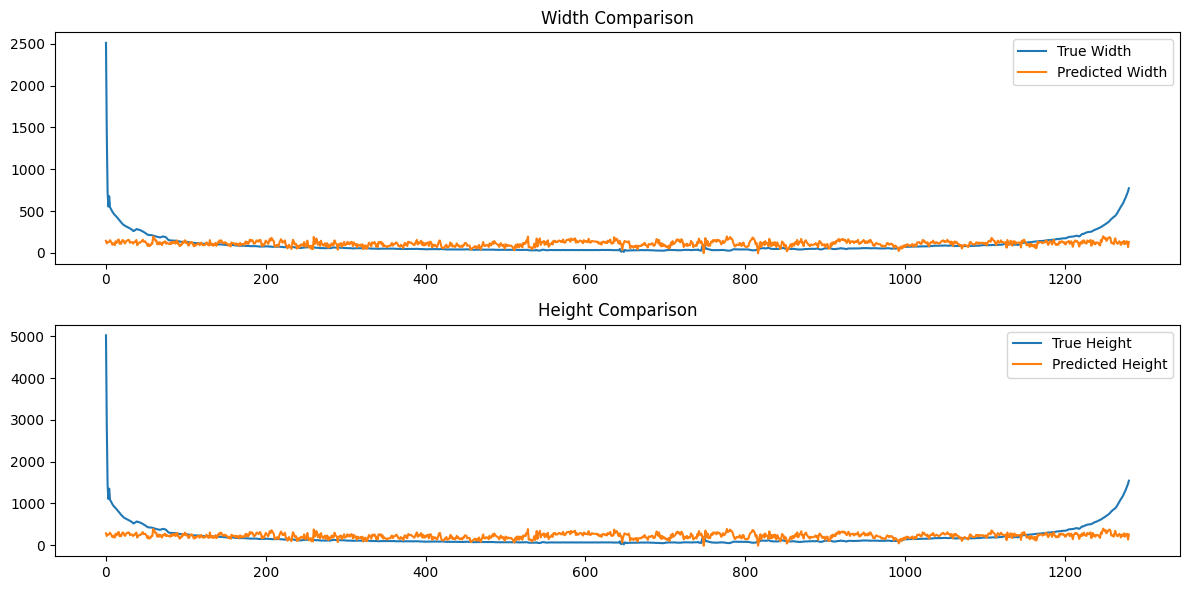

In [36]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

class ESN:
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9, alpha=0.99):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius
        self.alpha = alpha

        self.W_in = np.random.rand(reservoir_size, input_size + 1) - 0.5  # bias term
        self.W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5 # bias term
        self.W_out = np.random.rand(output_size, reservoir_size) - 0.5    # bias term

        self.W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_res)))

    def train(self, X_train, y_train, transient=100):
        X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_train), self.reservoir_size))
        x = np.zeros(self.reservoir_size)

        for t in range(len(X_train)):
            u = X_train[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            if t > transient:
                X_res[t] = x

        self.W_out = np.dot(np.linalg.pinv(X_res[transient:]), y_train[transient:])

    def predict(self, X_test):
        X_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_test), self.reservoir_size))
        x = np.zeros(self.reservoir_size)

        for t in range(len(X_test)):
            u = X_test[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            X_res[t] = x

        return np.dot(X_res, self.W_out)

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def get_bounding_box(frame, bbox):
    x, y, w, h = bbox
    height, width = frame.shape[:2]
    
    x = max(0, min(x, width - 1))
    y = max(0, min(y, height - 1))
    w = max(1, min(w, width - x))
    h = max(1, min(h, height - y))
    
    return frame[y:y+h, x:x+w]

def preprocess_bounding_boxes(df, frames, target_size=(64, 64)):
    X = []
    y = []
    for i, bbox in df.iterrows():
        frame = frames[i]
        crop = get_bounding_box(frame, (bbox['x'], bbox['y'], bbox['w'], bbox['h']))
        
        if crop.size == 0:
            continue
        
        crop_resized = cv2.resize(crop, target_size)
        X.append(crop_resized.flatten())
        y.append([bbox['w'], bbox['h']])
        
    return np.array(X), np.array(y)

# Load data from CSV files
first_video_df = pd.read_csv('assets/pedestrian/crosswalk.csv')
second_video_df = pd.read_csv('assets/pedestrian/fourway.csv')

# Load video frames
first_video_frames = load_video_frames('assets/pedestrian/crosswalk.avi')
second_video_frames = load_video_frames('assets/pedestrian/fourway.avi')

# Prepare data
X_train, y_train = preprocess_bounding_boxes(first_video_df, first_video_frames)
X_test, y_test = preprocess_bounding_boxes(second_video_df, second_video_frames)

# Initialize and train ESN model
input_size = X_train.shape[1] 
reservoir_size = 500
output_size = 2  # w, h
esn = ESN(input_size, reservoir_size, output_size)

esn.train(X_train, y_train)

predictions = esn.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test[:, 0], label='True Width')
plt.plot(predictions[:, 0], label='Predicted Width')
plt.legend()
plt.title('Width Comparison')
plt.subplot(2, 1, 2)
plt.plot(y_test[:, 1], label='True Height')
plt.plot(predictions[:, 1], label='Predicted Height')
plt.legend()
plt.title('Height Comparison')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def get_bounding_box(frame, bbox):
    x, y, w, h = bbox
    return frame[y:y+h, x:x+w]

def preprocess_bounding_boxes(df, frames, target_size=(64, 64)):
    X = []
    y = []
    for i, bbox in df.iterrows():
        frame = frames[i]
        if frame is None:
            continue
        x, y_coord, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        if x + w <= frame.shape[1] and y_coord + h <= frame.shape[0]:
            crop = get_bounding_box(frame, (x, y_coord, w, h))
            if crop.size > 0:
                crop_resized = cv2.resize(crop, target_size)
                X.append(crop_resized.flatten())
                y.append([x, y_coord, w, h])
    return np.array(X), np.array(y)

def draw_bounding_box(frame, bbox):
    x, y, w, h = bbox
    return cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

def create_video_with_predictions(video_frames, initial_bboxes, predictions, output_path, fps=30):
    height, width, _ = video_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i, frame in enumerate(video_frames):
        if i < len(predictions):
            #x = initial_bboxes.iloc[i]['x']
            #y = initial_bboxes.iloc[i]['y']
            x = int(predictions[i, 0])
            y = int(predictions[i, 1])
            w_pred = int(predictions[i, 2])
            h_pred = int(predictions[i, 3])
            bbox = (x, y, w_pred, h_pred)
            frame_with_bbox = draw_bounding_box(frame.copy(), bbox)
            out.write(frame_with_bbox)

    out.release()

# Load data from CSV files
first_video_df = pd.read_csv('assets/pedestrian/fourway.csv')
#second_video_df = pd.read_csv('assets/pedestrian/crosswalk.csv')

# Load video frames
first_video_frames = load_video_frames('assets/pedestrian/fourway.avi')
#second_video_frames = load_video_frames('assets/pedestrian/crosswalk.csv')
print(len(first_video_frames))

# Prepare data
X_train, y_train = preprocess_bounding_boxes(first_video_df, first_video_frames)
#X_test, y_test = preprocess_bounding_boxes(second_video_df, second_video_frames)
X_test, y_test = X_train, y_train


# Initialize and train ESN model
input_size = X_train.shape[1]  # Number of pixels in the flattened cropped image
reservoir_size = 2000
output_size = 4  # x, y, w, h
esn = ESN(input_size, reservoir_size, output_size)

print(len(y_train))
esn.train(X_train, y_train)

# Predict using the trained model
predictions = esn.predict(X_test)
print(len(predictions))

# Create video with predicted bounding boxes
create_video_with_predictions(first_video_frames, first_video_df, predictions, 'output_with_predictions.avi')

print("Video with predicted bounding boxes saved as 'output_with_predictions.avi'")


1281
1244
1244
Video with predicted bounding boxes saved as 'output_with_predictions.avi'


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the autoencoder
def build_autoencoder(input_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_img)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    # Decoder
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder, encoder

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Normalize pixel values to range [0, 1]
X = np.array(X)
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train autoencoder
input_dim = X_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Transform data using the encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Initialize and train ESN
input_size = X_train_encoded.shape[1]
reservoir_size = 1000
output_size = 10
esn = ESN(input_size, reservoir_size, output_size, alpha=0.99)
esn.train(X_train_encoded, y_train)

predictions = []
for i in X_test_encoded:
    predictions.append(esn.predict(i.reshape(1, -1)))
predictions = np.array(predictions).reshape(-1, 10)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)
print("The input dimension is:", X_train_encoded.shape[1])
try:
    print("The dimension is:", X_train_encoded)
except:
    pass

c:\Users\ghorb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(




Epoch 1/50

175/175 [==============================] - 4s 16ms/step - loss: 0.2101 - val_loss: 0.1334
Epoch 2/50
175/175 [==============================] - 3s 15ms/step - loss: 0.1176 - val_loss: 0.1065
Epoch 3/50
175/175 [==============================] - 3s 16ms/step - loss: 0.1002 - val_loss: 0.0963
Epoch 4/50
175/175 [==============================] - 3s 16ms/step - loss: 0.0922 - val_loss: 0.0899
Epoch 5/50
175/175 [==============================] - 4s 21ms/step - loss: 0.0878 - val_loss: 0.0869
Epoch 6/50
175/175 [==============================] - 5s 26ms/step - loss: 0.0849 - val_loss: 0.0844
Epoch 7/50
175/175 [==============================] - 5s 27ms/step - loss: 0.0825 - val_loss: 0.0823
Epoch 8/50
175/175 [==============================] - 5s 28ms/step - loss: 0.0808 - val_loss: 0.0804
Epoch 9/50
175/175 [==============================] - 4s 25ms/step - loss: 0.0795 - val_loss: 0.0791
Epoch 10/50
175/175 [==============================] - 5s 29ms/step - loss: 0.0783 - val

Epoch 1/50
235/235 [==============================] - 3s 8ms/step - loss: 0.2252 - val_loss: 0.1411
Epoch 2/50
235/235 [==============================] - 2s 6ms/step - loss: 0.1248 - val_loss: 0.1116
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1079 - val_loss: 0.1020
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1003 - val_loss: 0.0960
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0953 - val_loss: 0.0919
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0918 - val_loss: 0.0896
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0894 - val_loss: 0.0874
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0877 - val_loss: 0.0863
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0863 - val_loss: 0.0846
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0850 - val_loss: 0.0834

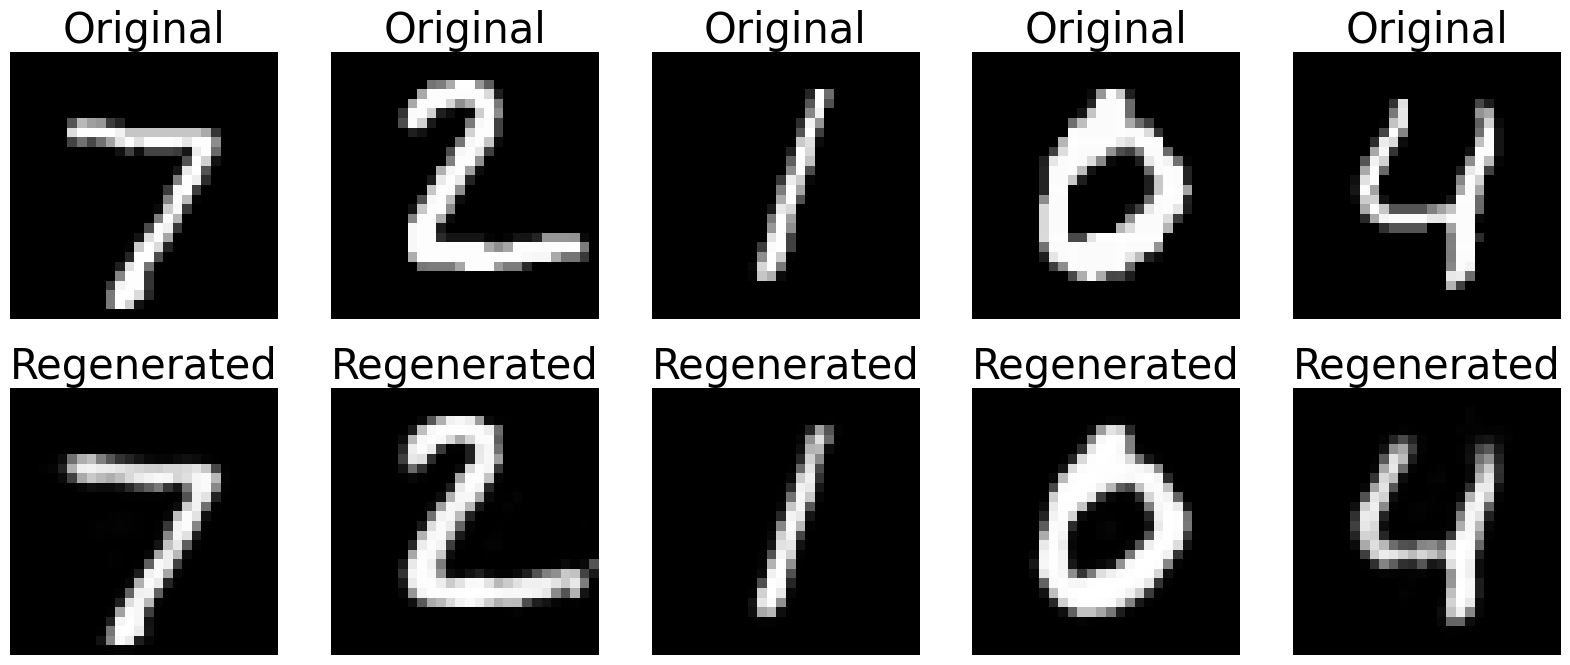

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Autoencoder architecture
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

# Decoder
x = Dense(128, activation='relu')(encoded)
x = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Generate regenerated dataset
decoded_imgs = autoencoder.predict(x_test)

# Display original and regenerated images
n = 5  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original", fontsize=30)
    plt.axis('off')
    
    # Display regenerated (decoded) image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Regenerated", fontsize=30)
    plt.axis('off')
plt.show()
